# Ess 330 Final Report

Chippy Marx (CSU)  
Chris Drew (CSU)

# Abstract

# Introduction

# Methods

**Data importing and initial cleaning**

Before we could do any of our analysis, we had to import our projected spatial data, and extract the raster values from it. The historic invasive species data we had did not have latitude and longitude, which was important for  analysis, so we found a dataset that had these values and shared site identifier values. We did an inner-join on these two datasets, and then selected only the attributes we would need for analysis to make the dataset smaller, filtered to the year we were interested in (2007), and removed missing values.  We had to prepare the spatial point data with the extracted raster values by filtering and formatting the dataset so that it was clean. Then, we  transformed the coordinate system of our historic data in order to match that of the raster data , or our projected dataset. Next we extracted the raster values from our projected dataset for the sites we had in our historic data set. We then binded these extracted values with the points in our historic dataset to create a new dataset where each row had both spatial and raster-derived information.

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──
✔ broom        1.0.8     ✔ rsample      1.3.0
✔ dials        1.4.0     ✔ tune         1.3.0
✔ infer        1.0.8     ✔ workflows    1.2.0
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.3.1     ✔ yardstick    1.3.2
✔ recipes      1.3.0     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()

terra 1.8.42

Attaching package: 'terra'

The following object is masked from 'package:dials':

    buffer

The following object is masked from 'package:scales':

    rescale

The following object is masked from 'package:tidyr':

    extract

Linking to GEOS 3.13.0, GDAL 3.8.5, PROJ 9.5.1; sf_use_s2() is TRUE

In [ ]:
# bring in forb data 
r <- rast(c(
  "data/sl_forb_current.tiff",
  "data/sl_forb_mid_585.tiff",
  "data/sl_forb_late_585.tiff"
))

#bring in grass data 
g <- rast(c('data/sl_grass_current.tiff','data/sl_grass_late_585.tiff', 'data/sl_grass_mid_585.tiff' ))


# Load and join historic  data
Invasive_data <- read_csv("data/CO_INVASIVE_SUBPLOT_SPP.csv")

Rows: 3975 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): VEG_FLDSPCD, VEG_SPCD
dbl  (13): CN, PLT_CN, INVYR, STATECD, UNITCD, COUNTYCD, PLOT, SUBP, CONDID,...
lgl   (1): MODIFIED_DATE
dttm  (1): CREATED_DATE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 29168 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): ECOSUBCD, ROADLESSCD, FVS_VARIANT
dbl  (16): CN, STATECD, INVYR, UNITCD, COUNTYCD, PLOT, LAT, LON, CONGCD, HUC...
lgl   (3): FVS_DISTRICT, ECO_UNIT_PNW, PRECIPITATION
dttm  (2): CREATED_DATE, MODIFIED_DATE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

*In our analysis we preformed two main tests: one visually analyzing the trend of invasive forb and grass coverage across ten sites of interest, and one unsupervised machine learning model using k-means to predict mid-century invasive forb coverage.*

### **Test 1: Visualizations**

For this visual test we selected 10 sites from the map, trying to spread out across the state. We then created faceted scatter plots for 10 randomly selected sites of invasive forb and grass cover by three time points: Current, Mid-century (2040–2060), and Late-century (2080–2100) for the SSP585 climate scenario. The plots allowed us to examine visually vegetation cover trends without predictive modeling.

In [ ]:
#sites we will select, project
site_ids = c(12224885010690, 12221198010690, 12223803010690, 12206792010690, 12222071010690, 1223416010690, 12225851010690, 12232600010690, 12212814010690,     12214073010690  ) 

#filer spatial data to only include the 10 sites of interest, then reproject. 
ex_pts = pts %>% 
  filter(PLT_CN %in% site_ids) %>% 
  st_transform(crs(r))

#extract raster values and bind comlums 
v <- terra::extract(r, ex_pts)
ex_Pts_both = bind_cols(ex_pts, v)

#do the same for grass data 
ex_pts_g = pts %>% 
  filter(PLT_CN %in% site_ids) %>% 
  st_transform(crs(g))

g <-  terra::extract(g, ex_pts_g)
ex_Pts_both_g = bind_cols(ex_pts_g, g)

ex_pts = pts %>% 
  filter(PLT_CN %in% site_ids) %>% 
  #distinct() %>% 
  st_transform(crs(r))

v <-  terra::extract(r, ex_pts)
ex_Pts_both = bind_cols(ex_pts, v)

#point of this is ... for forb 
df_long <- ex_Pts_both %>%
  select(ID, COVER_PCT, sl_forb_current, sl_forb_mid_585, sl_forb_late_585) %>%
  pivot_longer(
    cols = c(COVER_PCT, sl_forb_current, sl_forb_mid_585, sl_forb_late_585),
    names_to = "variable",
    values_to = "value"
  )

#for grass 
df_long_g <- ex_Pts_both_g %>%
  select(ID, COVER_PCT, sl_grass_current, sl_grass_mid_585, sl_grass_late_585) %>%
  pivot_longer(
    cols = c(COVER_PCT, sl_grass_current, sl_grass_mid_585, sl_grass_late_585),
    names_to = "variable",
    values_to = "value"
  )

*Plot Forbs*

In [ ]:
# Filter to 10 unique IDs
ten_ids_forb <- df_long %>% 
  distinct(ID) %>%
  slice_head(n = 10) %>%
  pull(ID)

df_subset_forb <- df_long %>%
  filter(ID %in% ten_ids_forb)

# Convert ID to factor to preserve facet order
df_subset_forb$ID <- factor(df_subset_forb$ID)

df_subset_forb <- df_subset_forb %>%
  mutate(
    variable = recode(variable,
      "COVER_PCT" = "2007 (Observed)",
      "sl_forb_current" = "Current (1981–2010)",
      "sl_forb_mid_585" = "Mid-century (2041–2070)",
      "sl_forb_late_585" = "Late-century (2071–2100)"
    ),
    scenario_label = case_when(
      variable == "2007 (Observed)" ~ "2007",
      variable == "Current (1981–2010)" ~ "Current",
      variable == "Mid-century (2041–2070)" ~ "Mid-century",
      variable == "Late-century (2071–2100)" ~ "Late-century",
      TRUE ~ NA_character_  # catch unmatched cases
    ),
    scenario_label = factor(scenario_label, levels = c("2007", "Current", "Mid-century", "Late-century"))
  ) %>%
  filter(!is.na(scenario_label))  # drop rows with NA scenario_label

# Plot
Forb_vis <- ggplot(df_subset_forb, aes(x = scenario_label, y = value, group = ID)) +
  geom_line(aes(color = variable), linewidth = 1) +
  geom_point(size = 2) +
  facet_wrap(~ ID, scales = "fixed", nrow = 2) +
  labs(
    x = "Scenario",
    y = "Cover Percentage",
    title = "Forb Cover Change by Site (10 Sample IDs)",
    color = "Scenario Timeframe"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text = element_text(size = 16, face = "bold"),
    plot.title = element_text(hjust = 0.5)
  )

*Plot Grasses*

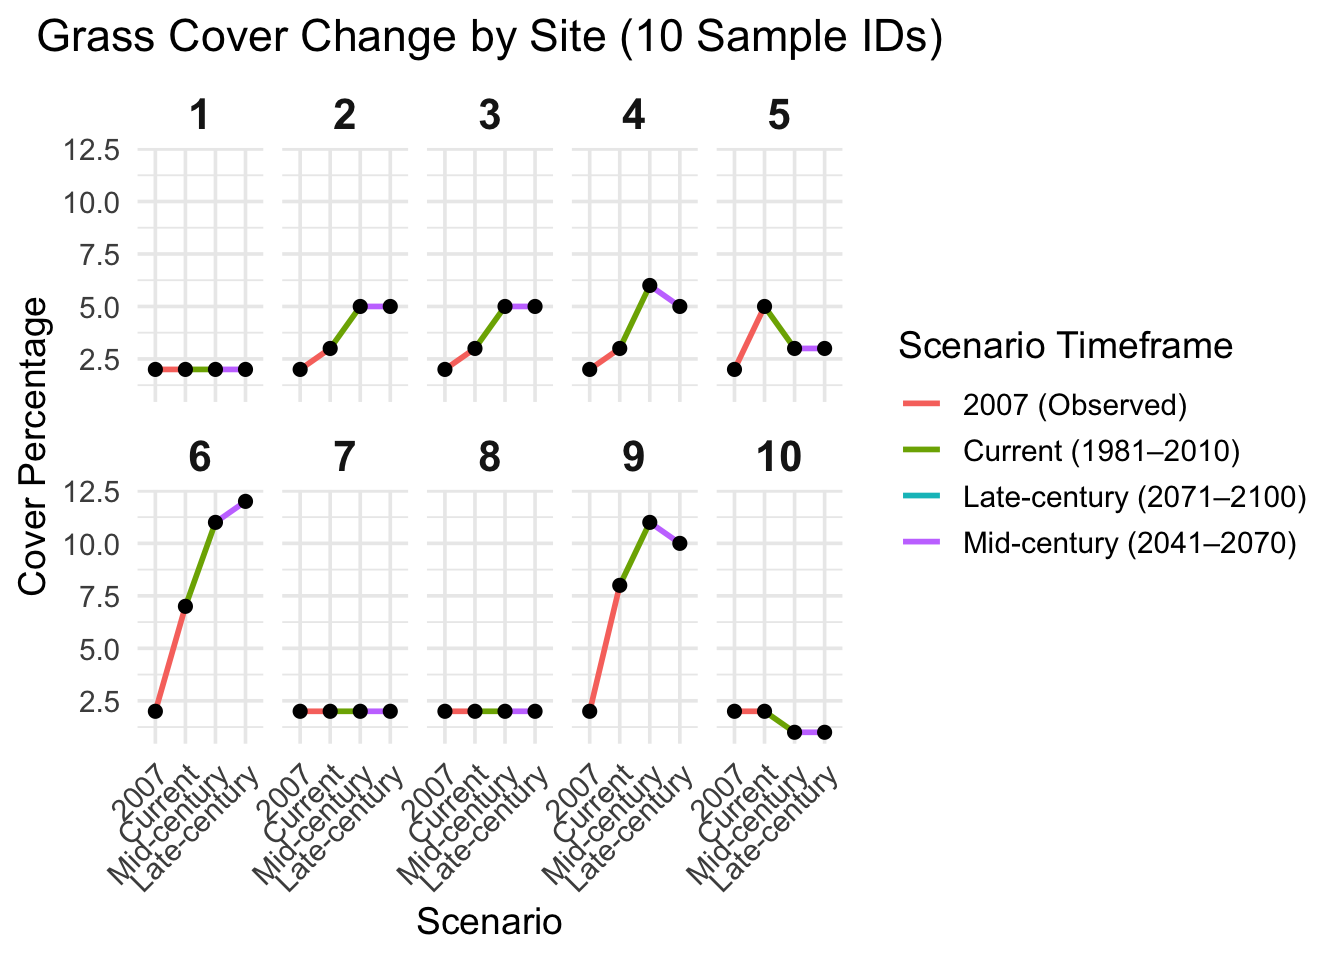

In [ ]:
# Filter to 10 unique IDs
ten_ids <- df_long_g %>% 
  distinct(ID) %>%
  slice_head(n = 10) %>%
  pull(ID)

df_subset <- df_long_g %>%
  filter(ID %in% ten_ids)

# Convert ID to factor to control facet order and labels
df_subset$ID <- factor(df_subset$ID)

df_subset_grass <- df_subset %>%
  mutate(
    # Detailed labels for the legend
    variable = recode(variable,
      "COVER_PCT" = "2007 (Observed)",
      "sl_grass_current" = "Current (1981–2010)",
      "sl_grass_mid_585" = "Mid-century (2041–2070)",
      "sl_grass_late_585" = "Late-century (2071–2100)"
    ),
    # Simplified x-axis labels
    scenario_label = case_when(
      variable == "2007 (Observed)" ~ "2007",
      variable == "Current (1981–2010)" ~ "Current",
      variable == "Mid-century (2041–2070)" ~ "Mid-century",
      variable == "Late-century (2071–2100)" ~ "Late-century",
      TRUE ~ NA_character_
    ),
    # Ensure factor order on x-axis
    scenario_label = factor(scenario_label, levels = c("2007", "Current", "Mid-century", "Late-century"))
  ) %>%
  filter(!is.na(scenario_label))  # remove any unmatched

# Plot
ggplot(df_subset_grass, aes(x = scenario_label, y = value, group = ID)) +
  geom_line(aes(color = variable), linewidth = 1) +
  geom_point(size = 2) +
  facet_wrap(~ ID, scales = "fixed", nrow = 2) +
  labs(
    x = "Scenario",
    y = "Cover Percentage",
    title = "Grass Cover Change by Site (10 Sample IDs)",
    color = "Scenario Timeframe"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text = element_text(size = 16, face = "bold"),
    plot.title = element_text(hjust = 0.5)
  )

**Building the reference map**

For these figures we wanted to create a reference map of where the 10 sites we chose were. To do this we laid our 10 sites (using their lat and long values) on a map of Colorado. Next, we added the labels of the sites to the data set. We had to transform the location values back to lat and lon as we had projected them in the coordinate system of our spatial data earlier. We then plotted this onto our map of Colorado.

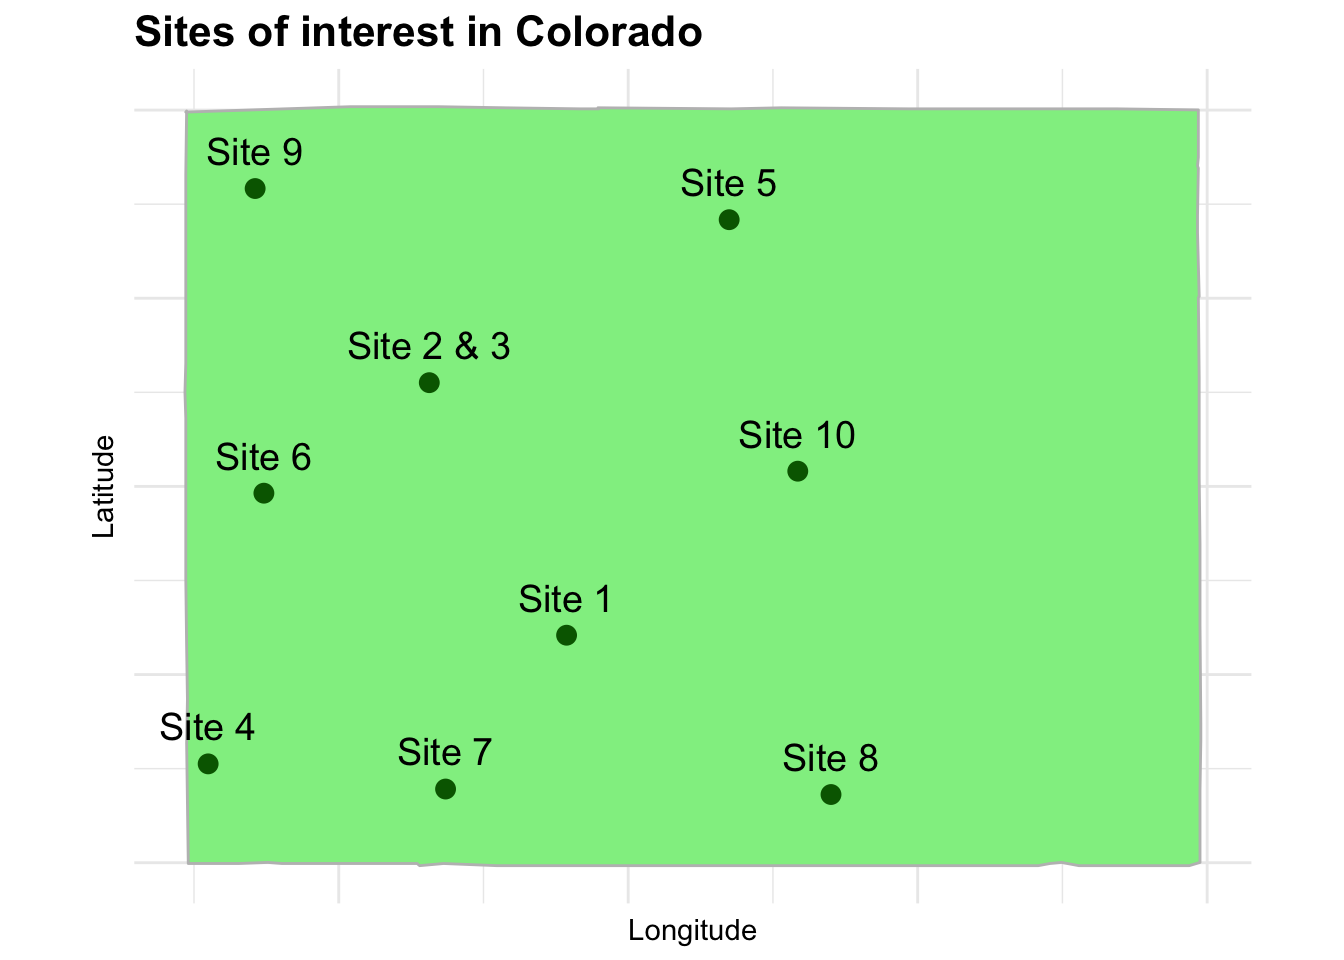

In [ ]:
# Get US state boundaries from base R maps
usa <- map_data("state")

# Filter for Colorado
colorado <- usa %>% filter(region == "colorado")

# Step 1: Add labels BEFORE converting to lat/lon
ex_pts$Label <- as.character(1:nrow(ex_pts))

# Step 2: Transform to lat/lon and extract coordinates
ex_pts_latlon <- st_transform(ex_pts, crs = 4326) %>% 
  mutate(
    lon = st_coordinates(.)[, 1],
    lat = st_coordinates(.)[, 2]
  ) %>%
  st_drop_geometry()

# Step 3: Group overlapping points and combine labels
ex_pts_latlon_grouped <- ex_pts_latlon %>%
  group_by(lon, lat) %>%
  summarise(Label = paste0("Site ", paste(Label, collapse = " & ")), .groups = "drop")

# Step 4: Plot
ggplot() +
  geom_polygon(data = colorado, aes(x = long, y = lat, group = group),
               fill = "lightgreen", color = "grey") +
  geom_point(data = ex_pts_latlon_grouped, aes(x = lon, y = lat), color = "darkgreen", size = 3) +
  geom_text(data = ex_pts_latlon_grouped, aes(x = lon, y = lat, label = Label), 
            nudge_y = 0.2, size = 5) +
  coord_fixed(1.3) +
  labs(title = "Sites of interest in Colorado",
       x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    axis.text = element_blank(),
    axis.ticks = element_blank()
  )

### Test 2: Unsupervised machine learning model using k-means.

First we got the state boundary for Colorado from the AOI package and projected it to the same coordinate reference system. We cropped all of the raster data to Colorado, then extracted all the raster values, removing all rows with missing data. 

Then we scaled the data with mean=1 and standard deviation=0 . This is important for K-means because it creates equal weighting of variables on different scales, and fair distance computation.  K-means uses euclidean distance, which is sensitive to scale, so scaling ensures all variables contribute equally to the clustering.

In [ ]:
library(terra)      
library(sf)          
library(tidyverse)   
library(tidymodels)  
library(remotes)

library(AOI)

library(climateR)


Attaching package: 'climateR'

The following object is masked from 'package:readr':

    parse_date

The following object is masked from 'package:graphics':

    plot

The following object is masked from 'package:base':

    plot


|---------|---------|---------|---------|
                                          


|---------|---------|---------|---------|
                                          

 We then performed K-means clustering**,** setting the maximum number of iterations the algorithm will run to refine the cluster assignments to 100. It is important to set a maximum  to avoid infinite loops in case convergence is slow**.** We randomly set the k-mean to 5. K-mean is a clustering algorithm used in unsupervised machine learning  to group data points into a specified number of clusters, based on similarity. Smaller K-means simplify the iteration, and avoid overfitting, but can lead to missing important subgroup differences; we did not worry about this in our study because the raster/projection data had very little variance to begin with.

In [ ]:
E <- kmeans(vs, 5, iter.max = 100)

clus_raster <- r[[1]]
values(clus_raster) <- NA
clus_raster[idx] <- E$cluster

Next we created a new raster for the cluster results, and mapped that. Next we combined the current and future forb predictions and the cluster rasters into a single stack; this builds a multi-layer raster stack for future analysis. This step is key for linking cluster ID’s to present and future landscape characteristics.

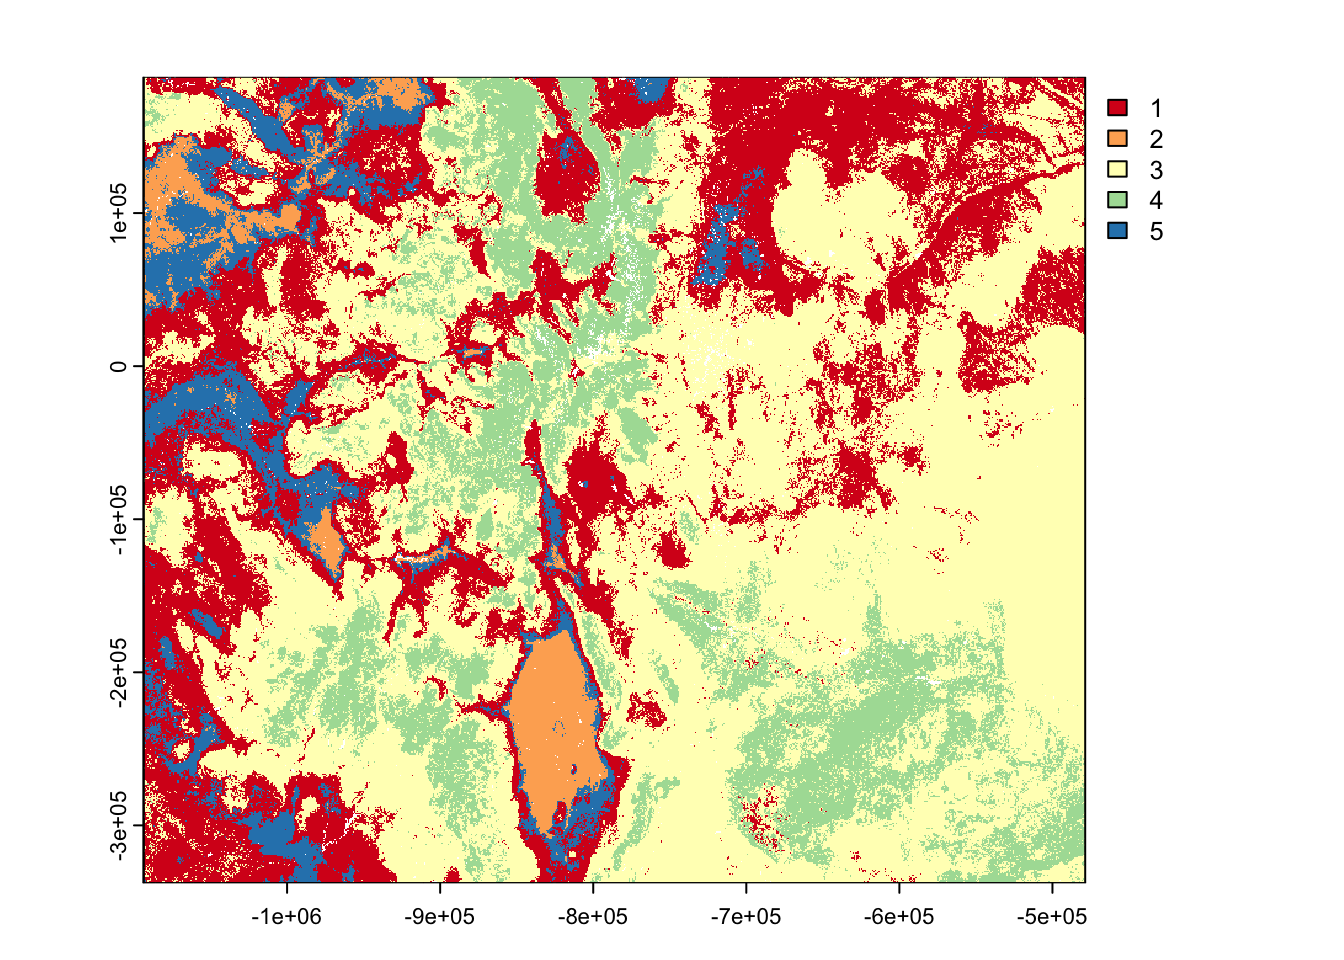

In [ ]:
plot(clus_raster, col = RColorBrewer::brewer.pal(5, "Spectral"))

Next we defined the climate variables we would use in creating our rasters. We chose maximum temperature (tmax), Precipitation (ppt), soil moisture content (soil), vapor pressure deficit (vpd), potential evapotranspiration (pet), and solar radiation (srad).  We chose tmax because it is critical for determining physiological threshold and growing season length (Hatfield & Prueger). We chose precipitation because it determines soil moisture and plant productivity (yiang). Soil moisture content was chosen because it influences plant establishment and competition; some invasive species can tolerate drought better or exploit moist soil more effectively than some natives (Zhang 2020). Potential evapotranspiration was chosen because it helps assess watr stress conditions, and invasices have been known to exploit these conditions (Lu). SRAD was chosen because it influences photosynthesis and growth, correlating with biomass and affecting competition dynamics (Zhang 2021). Vapor pressure deficit was chosen because it reflects atmospheric dryness; high VPD stresses plants, reducing native resistance and creating openings for invasives (Grossiord et. al 2020)

In [ ]:
params = c('tmax', "soil", "srad", "ppt", "vpd", "pet")

Next, using the TerraCLim package, setting the dates between 2015 and 2020, we binded that data to the raster data, extracting gM and mean. We split that bound data into training and testing sets, set a seed, and created  10-fold cross-validation splits. We then defined our 6 models, defined our recipe, normalizing all predictors and removing unwanted columns. We then tested each model with the metrics of root mean squared error (RMSE) and R2.

Rows: 3975 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): VEG_FLDSPCD, VEG_SPCD
dbl  (13): CN, PLT_CN, INVYR, STATECD, UNITCD, COUNTYCD, PLOT, SUBP, CONDID,...
lgl   (1): MODIFIED_DATE
dttm  (1): CREATED_DATE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 29168 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): ECOSUBCD, ROADLESSCD, FVS_VARIANT
dbl  (16): CN, STATECD, INVYR, UNITCD, COUNTYCD, PLOT, LAT, LON, CONGCD, HUC...
lgl   (3): FVS_DISTRICT, ECO_UNIT_PNW, PRECIPITATION
dttm  (2): CREATED_DATE, MODIFIED_DATE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 3965 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (12): ID, sl_forb_current, sl_grass_current, sl_forb_mid_585, sl_grass_m...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

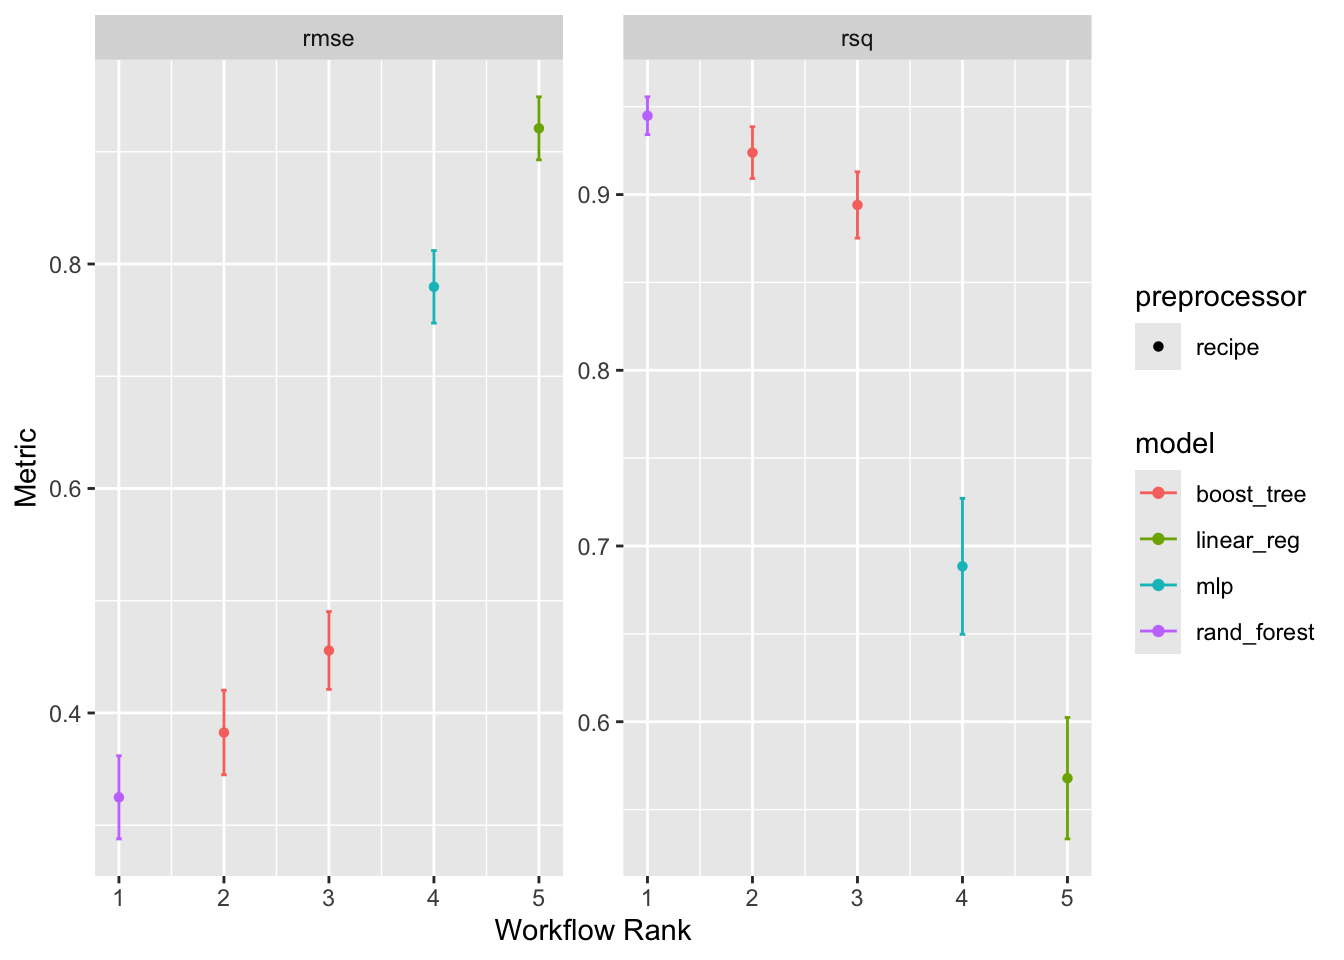

# A tibble: 5 × 9
  wflow_id          .config preproc model .metric .estimator  mean     n std_err
  <chr>             <chr>   <chr>   <chr> <chr>   <chr>      <dbl> <int>   <dbl>
1 recipe_linear_reg Prepro… recipe  line… rmse    standard   0.921    10  0.0171
2 recipe_xgboost    Prepro… recipe  boos… rmse    standard   0.456    10  0.0211
3 recipe_lightgbm   Prepro… recipe  boos… rmse    standard   0.383    10  0.0229
4 recipe_mlp        Prepro… recipe  mlp   rmse    standard   0.780    10  0.0196
5 recipe_rand_fore… Prepro… recipe  rand… rmse    standard   0.325    10  0.0225

In [ ]:
# Download TerraClim climate data for Colorado (2015–2020 average)
gM = climateR::getTerraClim(co, params, 
                            startDate = "2015-01-01", 
                            endDate   = "2020-12-31") 


# Load field plot data (data from 2007) and join with plot geometries
pts <- inner_join(read_csv("data/CO_INVASIVE_SUBPLOT_SPP.csv"), 
                  read_csv("data/CO_PLOTGEOM.csv"), 
                  by = c("PLT_CN" = 'CN')) %>% 
  st_as_sf(coords = c("LON", 'LAT'), crs = 4326) |> 
  st_transform(crs)

Our results showed that the random forest model performed the best with a RMSE of 0.259 and a R2 value of 0.954.  We fit the random forest model to the training data, and tuned the hyperparameters of mtry, trees, and min_n. Mtry was tuned because it controls the number of predictor variables selected at each split; high mtry reduces the randomness of the model. We tuned trees as it controls the number of decision trees; more trees means better performance to a point, but slower training. We tuned min_n which controls the number of data points a node must have to be split further; higher values create underfitting, and lower creates overfitting.

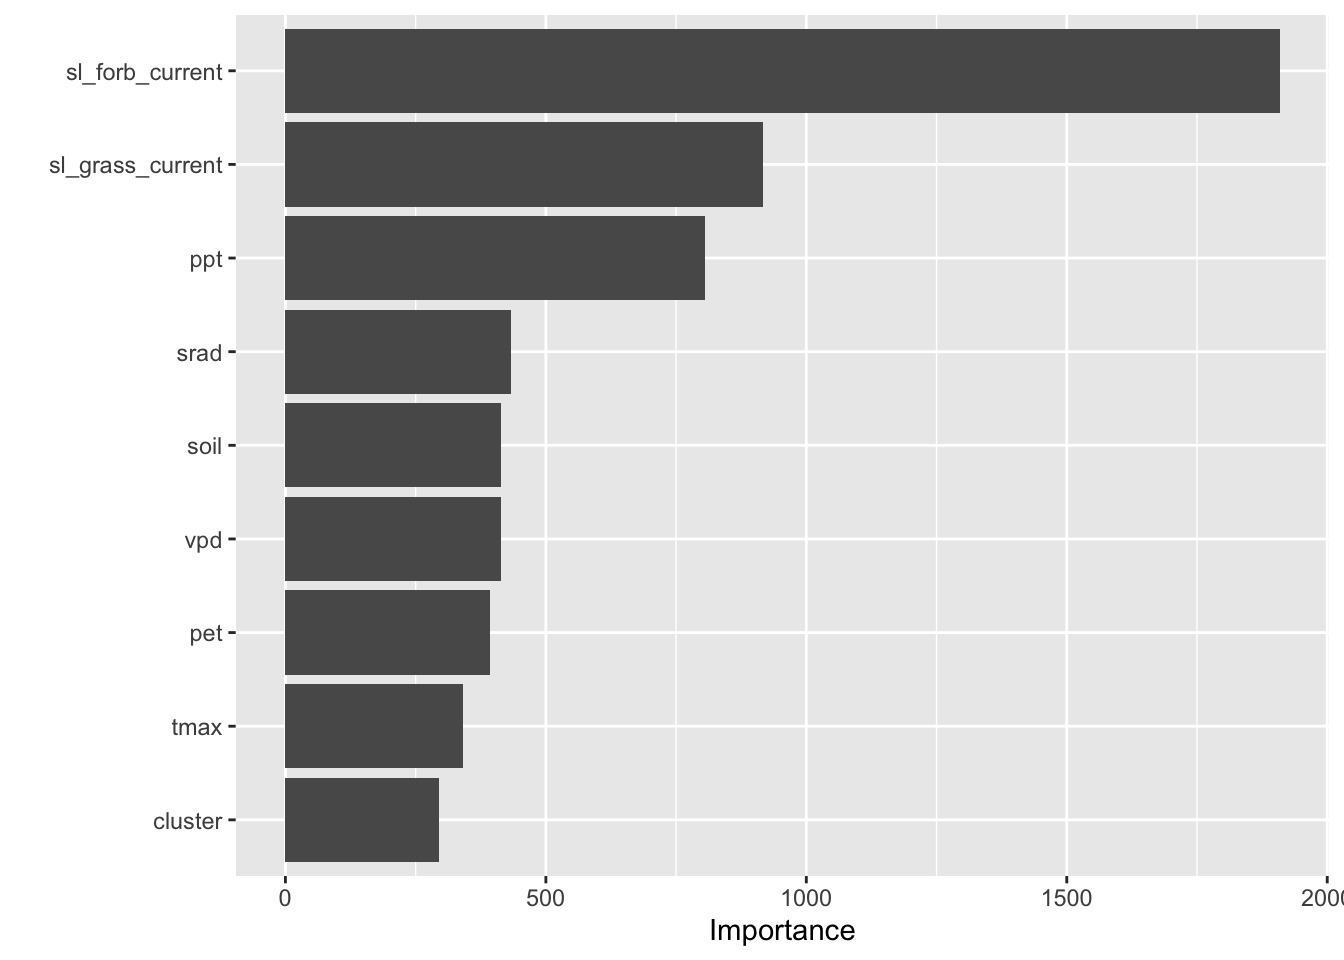

In [ ]:
# Build a single workflow with random forest model
wf = workflow() |> 
  add_recipe(rec) |> 
  add_model(rf_mod) 

# Fit the random forest to training data
wf_f = wf |> 
  fit(data = training) 

# Visualize feature importance (tells you which feature/variable was most important in making predictions)
vip::vip(wf_f)

We then performed a grid search to find the best combination of hyperparameters,and then finalized the workflow with the best hyperparameter. Next we did a final fit on the test set, collecting the rsq metric. Finally we predicted on all of our data, and visualted the predictions across clusters. Lastly, we re-plottes the cluster data for ease of analysis .

i Creating pre-processing data to finalize unknown parameter: mtry

# A tibble: 5 × 9
   mtry trees min_n .metric .estimator  mean     n std_err .config              
  <int> <int> <int> <chr>   <chr>      <dbl> <int>   <dbl> <chr>                
1     6  1167     2 rsq     standard   0.950    10 0.00618 Preprocessor1_Model17
2     3   667     3 rsq     standard   0.948    10 0.00642 Preprocessor1_Model08
3     7   417     6 rsq     standard   0.946    10 0.00630 Preprocessor1_Model20
4     5  1833     8 rsq     standard   0.944    10 0.00626 Preprocessor1_Model13
5     8  1666     9 rsq     standard   0.943    10 0.00638 Preprocessor1_Model22

# Resampling results
# Manual resampling 
# A tibble: 1 × 6
  splits             id               .metrics .notes   .predictions .workflow 
  <list>             <chr>            <list>   <list>   <list>       <list>    
1 <split [2973/992]> train/test split <tibble> <tibble> <tibble>     <workflow>

# A tibble: 2 × 4
  .metric .estimator .estimate .config             
  <chr>   <chr>          <dbl> <chr>               
1 rmse    standard       0.221 Preprocessor1_Model1
2 rsq     standard       0.966 Preprocessor1_Model1

`geom_smooth()` using formula = 'y ~ x'

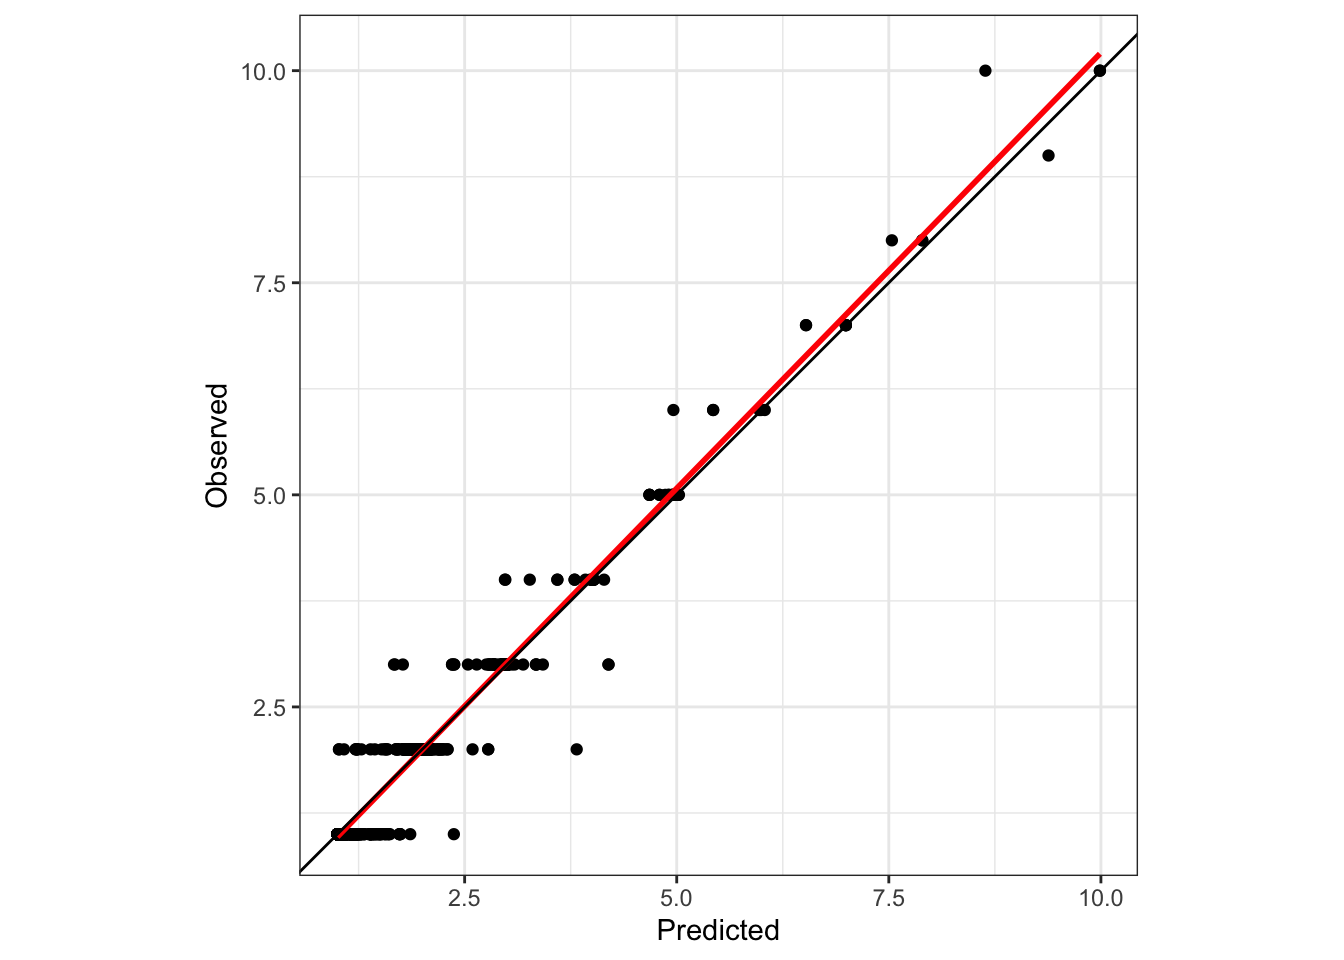

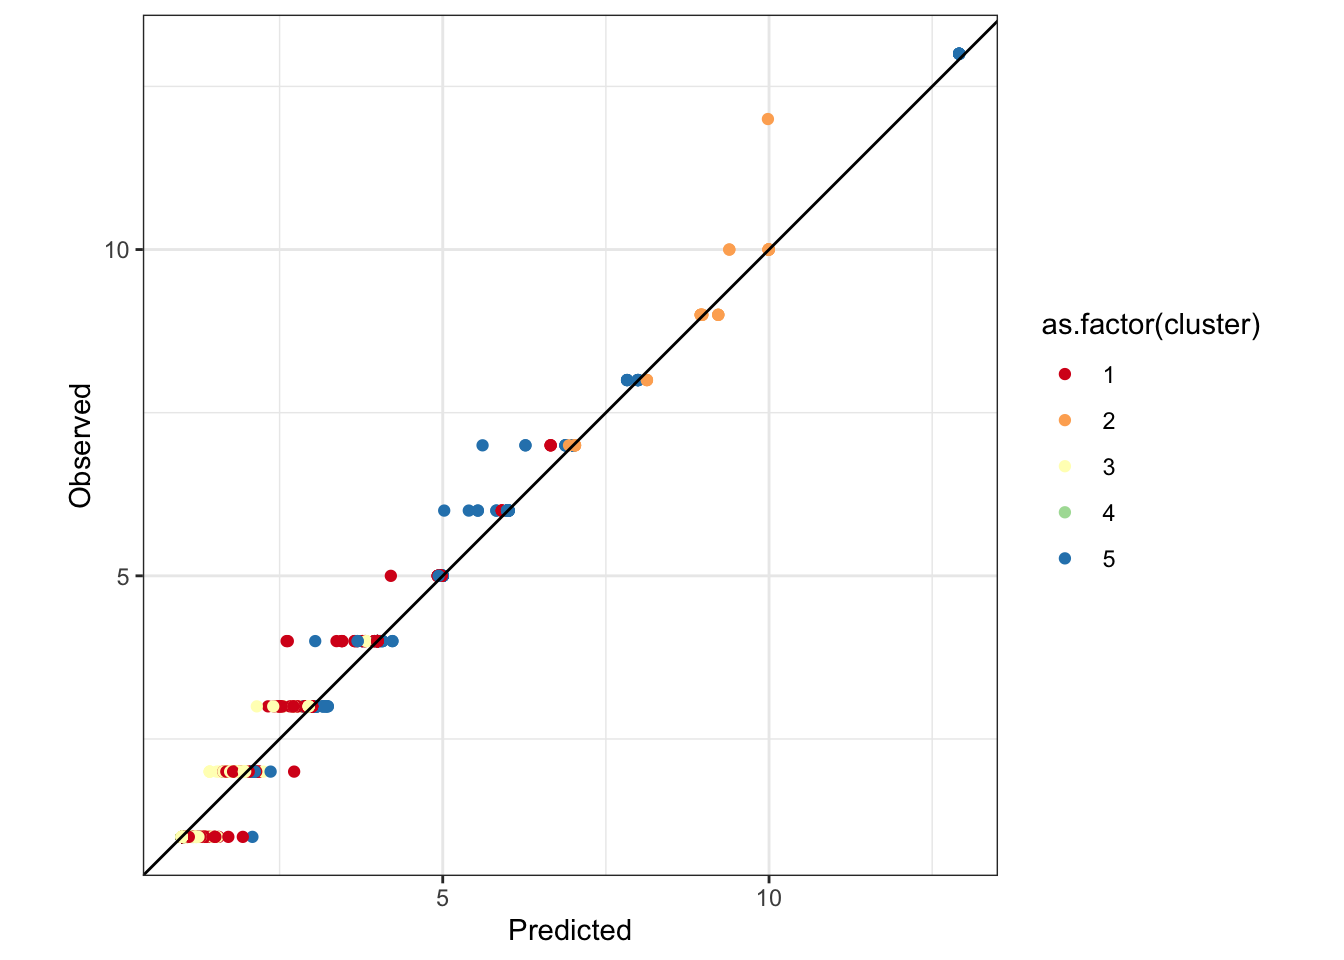

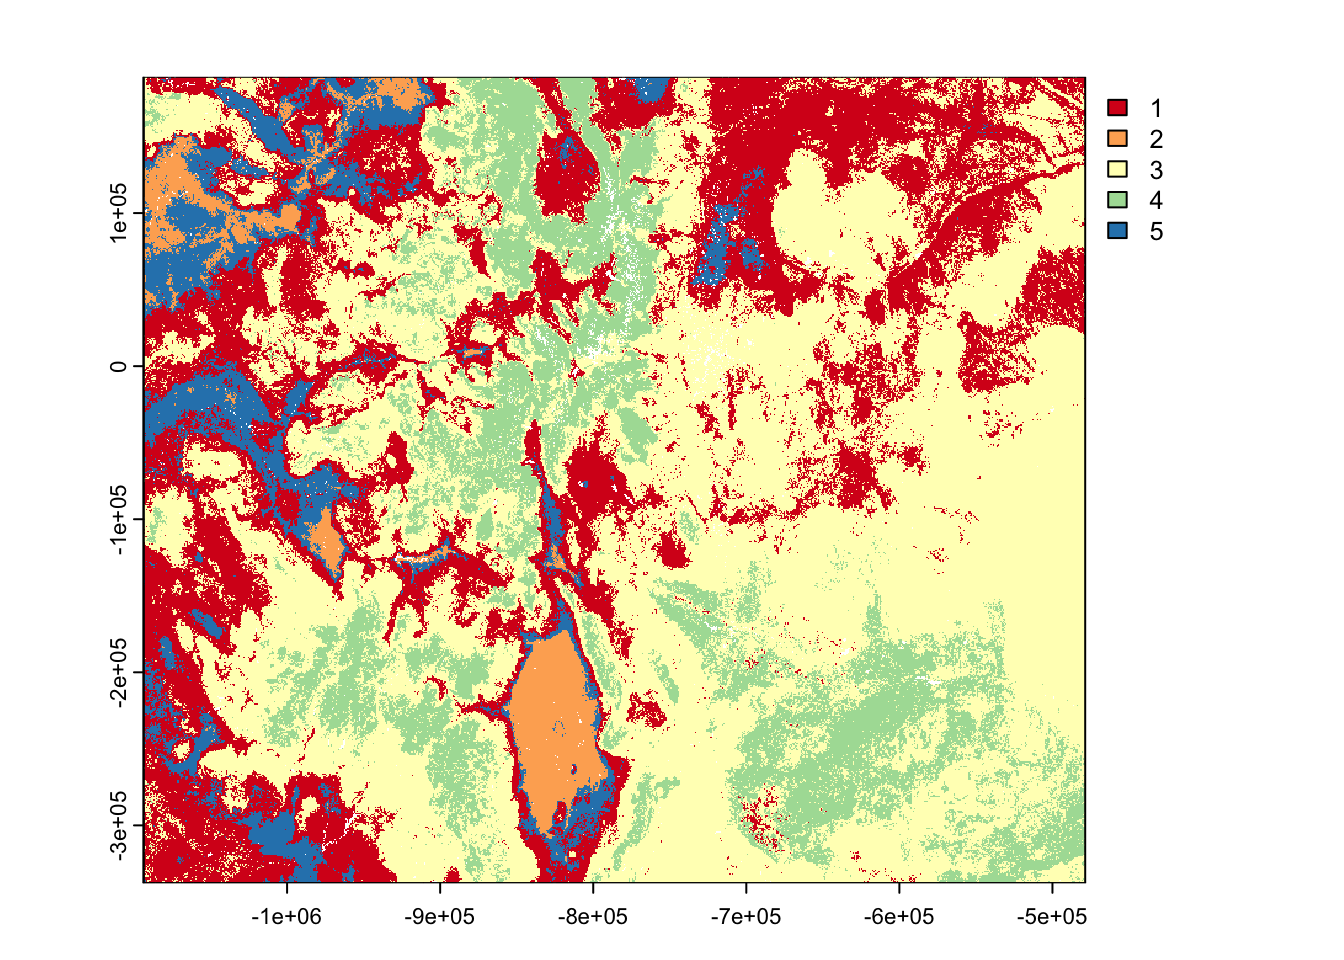

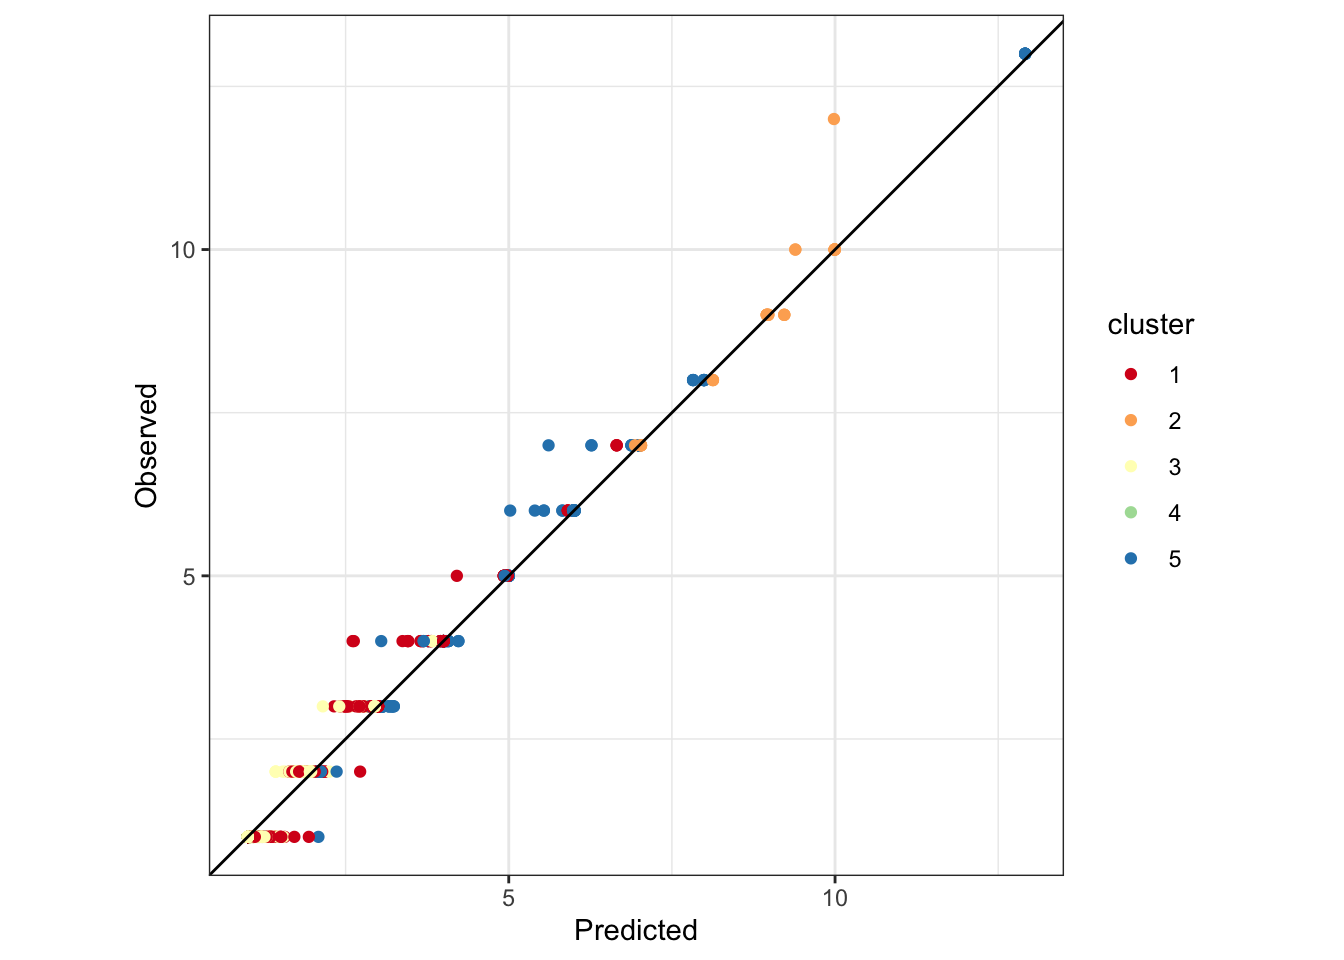

In [ ]:
tg = tune_grid(rf_t, 
               preprocessor = rec,
               resamples = folds, 
               grid = 25)

# Results

### Visual test

The visualizations provide an initial look into how forb and grass cover may shift under the projected climate scenario (SSP585). Forb cover showed considerable variation across the 10 selected sites when comparing the “Current,” “Mid-century,” and “Late-century” projections. Some sites exhibited clear declines in forb cover over time, while others maintained relatively stable levels or showed modest increases.

Grass cover showed a more consistent trend across sites. Most sites experienced a decline in grass cover across the three time periods. The one notable exception was the most westerly site, which displayed stability or a slight increase in grass cover under future climate projections.

### Unsupervised machine learning model using k-means.

Our final model had a root mean square error of 0.259, and an R-squared value of 0.968. We saw that the three most important variables in predicting invasive forb coverage were current invasive forb coverage, current invasive grass coverage and precipitation; with maximum temperature being the least important. We saw that in general, the model was better at predicting higher values, as the clusters #4 and #5 are closer to the regression line of predicted versus actual values. Higher values are clustered more towards the western part of the state, in general.

# Discussion

The analysis of our data relies heavily on climatic  and topographic maps  of Colorado. This is because our model was unsupervised, meaning that we were unable to retrieve or see the data that each cluster was pulling from. We will therefore analyze and discuss our results geographically.

### Test 1: Visual

Our initial visual observations suggest that both forb and grass cover can be significantly affected by projected late-century climate conditions. However, the response of these plant functional groups appears to vary by site and group.

**Site-Level Trends and Implications**

Forbs showed very variable patterns at sites. For example, some eastern slope sites had sharp forb declines, while others—those with unique microclimates or at higher elevations—had stable or even increasing forb cover. This diversity suggests that forb response to climate change potentially can be strongly site-specific, with localized environmental factors, species assemblages, or interactions not captured by large-scale climate variables being the decisive factors.

In contrast, grass cover also decreased in a more uniform manner at most locations, particularly on the east-facing slope. Such homogeneity could be a sign of a broader sensitivity of grasses to the imposed changes in temperature and precipitation regimes. The only exception was the site farthest west, where grass cover was more stable or even slightly increasing, highlighting the importance of geographic and climatic context for controlling vegetation response.

### Test 2: Unsupervised machine learning model using k-means.

The main limitation in our study was that the projected data that we had showed very little variation in Colorado. This led us to adding climatic data to create k-means in order to  provide our model more variation to predict off of. The reason we used k-means is that models are better at predicting means then a true model when variance in the data is low. 

The two most important variables in predicting invasive forb coverage mid century were current coverage of invasive forbs and grasses AS SEEN IN FIGURE . This is likely because these invasives are already present and taking hold. The presence of them in the area means they can disperse more easily into other nearby areas, and can start their process of dominance. The reason that invasive grass coverage was important in predicting future forb coverage is likely because these ecosystems are already disturbed, reducing their resilience and making them more susceptible to future invasions. 

Annual precipitation was the third most important variable in predicting future forb coverage. This makes sense, because as discussed in the methods section, precipitation  determines soil moisture and plant productivity (yiang). Because we ran an unsupervised model, we cannot see the underlying data that the clusters are pulling from. Therefor, we cannot be sure if high or low precipitation is associated with higher invasive coverage. However, looking at climate maps such as figure \_\_, we can deduce that because the higher forb coverage clusters are generally in the west, lower than average precipitation is associated with higher invasive coverage. While temperature did not prove to be very important in our model, based on figure\_\_ we see that in the west there have also been higher than average temperatures. These two conditions combined lead us to believe that Western Colorado is more susceptible to invasive forbs than Eastern Colorado due to the dramatically changing climatic conditions in the region. 

Another trend that we saw by looking at the cluster map FIGUTE and a  topographic map of Colorado FIGURE is that the two clusters with highest values are valleys. We believe this is because valleys rely on runoff from the mountains, in this case the Western Slope. If those areas do not receive as much precipitation, the valleys do not receive runoff and are water stressed

# Conclusions and Next steps

n both of our tests, we can see that areas expected to experience more prominent effects of climate change are more at risk for invasive plants in the future. This underscores the importance of avoiding 585 “worst case” climate scenarios. Policy needs to be enforced and participated in  globally that will prevent the emissions that would lead to this climate scenario. We know that invasive species are only one of the risks under this scenario, and maybe not even the most pressing, but they will further degrade these vulnerable ecosystems, and could lead to disruptions in disturbance regimes such as fire and disease.

If we had more time for this study, we would have several next steps. We would like to look into the connection between unprecedented forest fires in Colorado to see if these fires could be a predicting factor in invasive coverage. We would also like to test other disturbances such as historic fire suppression, urban sprawl,and disease to see if these could be trained into the model. 

We believe that further research needs to be done to analyze the functional groups discussed in this study, as well as specific invasives. Researchers still need to figure out how  invaders interact with things like competition from native plants or environmental conditions (Byun et al, 2018). This would provide insight into why these invaders are so successful, which could be used to inform management decisions. 

Ultimately , our study shows the importance of avoiding worst case scenario climate scenarios, identifying new and creative  ways to stop the spread and dominance of invasive species, and restoring native vegetation communities and ecosystems. Restoration will be an important part of our path forward in stopping invasive species dominance, as we know that healthy ecosystems do not foster invasive species, as their niches are full and functioning well(Byun et al, 2018).